# Application of `pyheatmy.frequency` to real MOLONARI data

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Loading the frequency module

In [27]:
from pyheatmy.frequency import frequency_analysis
fa = frequency_analysis()

Frequency analysis module initialized.
This module will analyze a multi-periodic signal to estimate attenuation and phase decay coefficients.
Using phase decay and amplitude attenuation with depth, we'll retrieve kappa_e and v_t for each dominant period.
-------------------------------------
Please use set_inputs(...) to provide the necessary data before analysis.


In [28]:
# df_signals = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point34_27_06_16/point34_temperature_cleaned.csv')
# df_river = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point34_27_06_16/point34_pression_cleaned.csv')

df_signals = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/point35_temperature_cleaned.csv')
df_river = pd.read_csv('/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/dataAnalysis/raw_data/point35_07_12_16/point35_pression_cleaned.csv')

In [29]:
df_signals

,dates,Temp_profondeur_10,Temp_profondeur_20,Temp_profondeur_30,Temp_profondeur_40
0,12-07-2016 13:45,15.151,14.050,14.122,14.170
1,12-07-2016 14:00,15.151,14.026,14.074,14.122
2,12-07-2016 14:15,15.199,14.002,14.050,14.098
3,12-07-2016 14:30,15.223,14.002,14.026,14.074
4,12-07-2016 14:45,15.270,14.002,14.002,14.074
...,...,...,...,...,...
1636,31-07-2016 13:00,14.601,13.858,13.882,14.170
1637,31-07-2016 13:15,14.625,13.858,13.882,14.170
1638,31-07-2016 13:30,14.697,13.858,13.858,14.170
1639,31-07-2016 13:45,14.745,13.882,13.858,14.170


In [30]:
df_river['dates']

0       12-07-2016 13:45
1       12-07-2016 14:00
2       12-07-2016 14:15
3       12-07-2016 14:30
4       12-07-2016 14:45
              ...       
1636    31-07-2016 13:00
1637    31-07-2016 13:15
1638    31-07-2016 13:30
1639    31-07-2016 13:45
1640    31-07-2016 14:00
Name: dates, Length: 1641, dtype: object

In [31]:
def convertDates(df: pd.DataFrame):
    """
    Convert dates trying several explicit formats and a robust fallback.
    Works in-place on the DataFrame (assumes first column contains date strings).
    """
    times = df[df.columns[0]]

    # Candidate explicit formats (added hyphen variants)
    formats = (
        "%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
        "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
        "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p",
        "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
        "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p",
        "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
        "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p",
        "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
        # --- hyphen variants commonly found in your files:
        "%d-%m-%Y %H:%M:%S", "%d-%m-%Y %H:%M",
        "%d-%m-%y %H:%M:%S", "%d-%m-%y %H:%M",
        "%Y-%m-%d %H:%M:%S", "%Y-%m-%d %H:%M",
        # fallback marker
        None
    )

    for f in formats:
        if f is None:
            break
        try:
            new_times = pd.to_datetime(times, format=f)
            # preserve original ordering check (optional)
            new_ts = new_times.values.astype(np.int64)
            test = np.sort(new_ts) - new_ts
            if np.sum(np.abs(test)) != 0:
                # ordering mismatch -> not this format
                raise ValueError("Order mismatch for format " + str(f))
            df[df.columns[0]] = new_times
            return
        except Exception:
            continue

    # Fallback: try generic parsing with dayfirst and infer
    # This often handles '12-07-2016 13:45' correctly.
    try:
        new_times = pd.to_datetime(times, dayfirst=True, infer_datetime_format=True, errors='raise')
        # final ordering check
        new_ts = new_times.values.astype(np.int64)
        test = np.sort(new_ts) - new_ts
        if np.sum(np.abs(test)) != 0:
            raise ValueError("Order mismatch after fallback parsing")
        df[df.columns[0]] = new_times
        return
    except Exception as e:
        # Last resort: try replacing '-' with '/' then parse
        try:
            times2 = times.astype(str).str.replace('-', '/')
            new_times = pd.to_datetime(times2, dayfirst=True, infer_datetime_format=True, errors='raise')
            new_ts = new_times.values.astype(np.int64)
            test = np.sort(new_ts) - new_ts
            if np.sum(np.abs(test)) != 0:
                raise ValueError("Order mismatch after dash->slash fallback")
            df[df.columns[0]] = new_times
            return
        except Exception:
            raise ValueError("Cannot convert dates: No known formats match your data!") from e

In [32]:
# def convertDates(df: pd.DataFrame):
#     """
#     Convert dates from a list of strings by testing several different input formats
#     Try all date formats already encountered in data points
#     If none of them is OK, try the generic way (None)
#     If the generic way doesn't work, this method fails
#     (in that case, you should add the new format to the list)
    
#     This function works directly on the giving Pandas dataframe (in place)
#     This function assumes that the first column of the given Pandas dataframe
#     contains the dates as characters string type
    
#     For datetime conversion performance, see:
#     See https://stackoverflow.com/questions/40881876/python-pandas-convert-datetime-to-timestamp-effectively-through-dt-accessor
#     """
#     formats = ("%m/%d/%y %H:%M:%S", "%m/%d/%y %I:%M:%S %p",
#                "%d/%m/%y %H:%M",    "%d/%m/%y %I:%M %p",
#                "%m/%d/%Y %H:%M:%S", "%m/%d/%Y %I:%M:%S %p", 
#                "%d/%m/%Y %H:%M",    "%d/%m/%Y %I:%M %p",
#                "%y/%m/%d %H:%M:%S", "%y/%m/%d %I:%M:%S %p", 
#                "%y/%m/%d %H:%M",    "%y/%m/%d %I:%M %p",
#                "%Y/%m/%d %H:%M:%S", "%Y/%m/%d %I:%M:%S %p", 
#                "%Y/%m/%d %H:%M",    "%Y/%m/%d %I:%M %p",
#                None)
#     times = df[df.columns[0]]
#     for f in formats:
#         try:
#             # Convert strings to datetime objects
#             new_times = pd.to_datetime(times, format=f)
#             # Convert datetime series to numpy array of integers (timestamps)
#             new_ts = new_times.values.astype(np.int64)
#             # If times are not ordered, this is not the appropriate format
#             test = np.sort(new_ts) - new_ts
#             if np.sum(abs(test)) != 0 :
#                 #print("Order is not the same")
#                 raise ValueError()
#             # Else, the conversion is a success
#             #print("Found format ", f)
#             df[df.columns[0]] = new_times
#             return
        
#         except ValueError:
#             #print("Format ", f, " not valid")
#             continue
    
#     # None of the known format are valid
#     raise ValueError("Cannot convert dates: No known formats match your data!")

In [33]:
convertDates(df_river)
convertDates(df_signals)

In [34]:
dates_river = df_river['dates']
dates_signals = df_signals['dates']

Check if dates are the same, if not we crop the data frames so that they both have the same dates

In [35]:
df_river_orig = df_river.copy()
df_signals_orig = df_signals.copy()

# Find intersection of dates (keep ordering consistent with df_river_orig)
common_set = set(df_river_orig['dates']).intersection(set(df_signals_orig['dates']))
if len(common_set) == 0:
    raise RuntimeError("No common timestamps found between df_river and df_signals!")

common = pd.Series(pd.to_datetime(sorted(list(common_set))))

# Build cropped, date-sorted dataframes
df_river_common = df_river_orig[df_river_orig['dates'].isin(common)].sort_values('dates').reset_index(drop=True)
df_signals_common = df_signals_orig[df_signals_orig['dates'].isin(common)].sort_values('dates').reset_index(drop=True)

# Optionally replace the working names so downstream cells use the cropped data
df_river = df_river_common.copy()
df_signals = df_signals_common.copy()

# Masks / leftover series for diagnostics
common_dates = df_river_orig['dates'].isin(common)            # boolean mask relative to original river df
river_only = df_river_orig[~common_dates]['dates'].reset_index(drop=True)
signals_only = df_signals_orig[~df_signals_orig['dates'].isin(common)]['dates'].reset_index(drop=True)

# Quick summary
print(f"Common timestamps: {len(common)}")
print(f"df_river original: {len(df_river_orig)} rows, df_signals original: {len(df_signals_orig)} rows")
print(f"After cropping -> df_river: {len(df_river)}, df_signals: {len(df_signals)}")
print(f"First/Last common timestamp: {common.iloc[0]}  ->  {common.iloc[-1]}")
if len(river_only):
    print(f"River-only timestamps: {len(river_only)} (first few):\n{river_only.head()}")
if len(signals_only):
    print(f"Signals-only timestamps: {len(signals_only)} (first few):\n{signals_only.head()}")

Common timestamps: 1641
df_river original: 1641 rows, df_signals original: 1641 rows
After cropping -> df_river: 1641, df_signals: 1641
First/Last common timestamp: 2016-07-12 13:45:00  ->  2016-07-31 14:00:00


In [36]:
dates = df_river['dates']
signals = [df_river['temperature_stream'].values,
           df_signals['Temp_profondeur_10'].values, 
           df_signals['Temp_profondeur_20'].values, 
           df_signals['Temp_profondeur_30'].values, 
           df_signals['Temp_profondeur_40'].values]

signals = [np.array(signal) for signal in signals]

depths = [0, 0.1, 0.2, 0.3, 0.4]

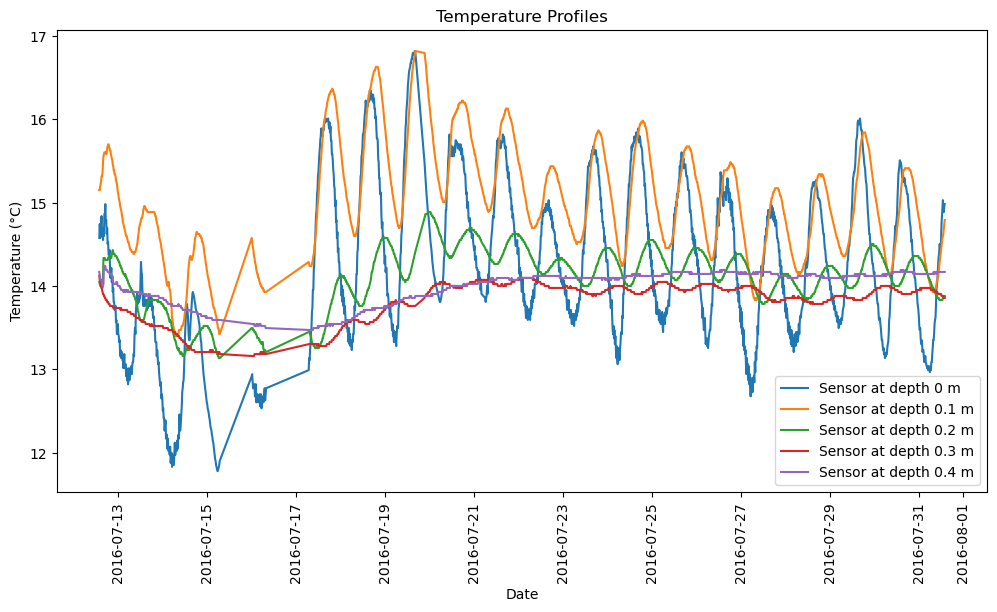

In [37]:
plt.figure(figsize=(12, 6))
for i, signal in enumerate(signals):
    plt.plot(dates, signal, label=f'Sensor at depth {depths[i]} m')

plt.xticks(rotation=90)
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.title('Temperature Profiles')
plt.legend()
plt.show()

Now try to launch frequential analysis.

In [38]:
fa.set_inputs(dates=dates, signals=signals, depths=depths)

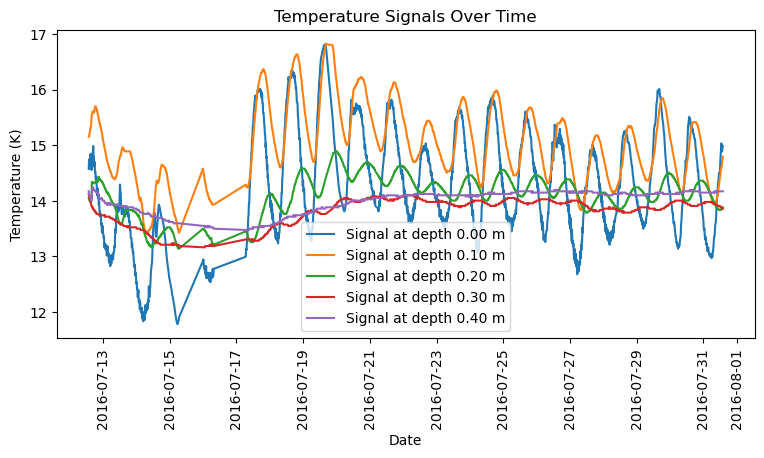

In [39]:
fa.plot_signals()

/Users/noedaniel/Desktop/MOLONARI/MOLONARI1D/pyheatmy/pyheatmy/frequency.py:447: RuntimeWarning: divide by zero encountered in divide
  plt.plot(1.0 / (freqs * 86400.0), amp, label=f'Sensor at depth {depths[i]} m')


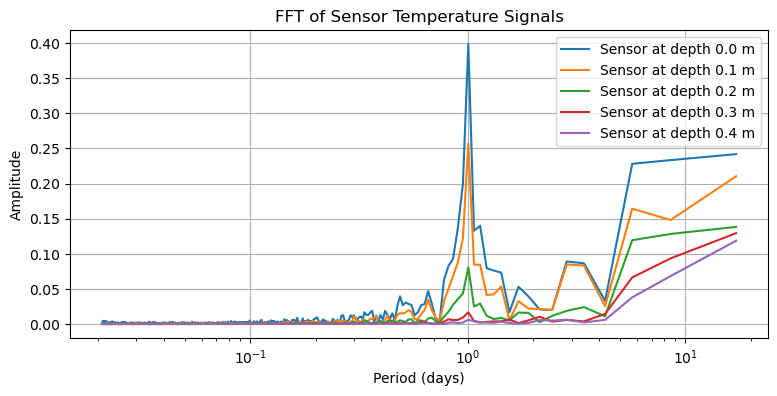

In [40]:
fa.fft_sensors()

We have to manually change the acceptance parameters otherwise, the point will not be detected.

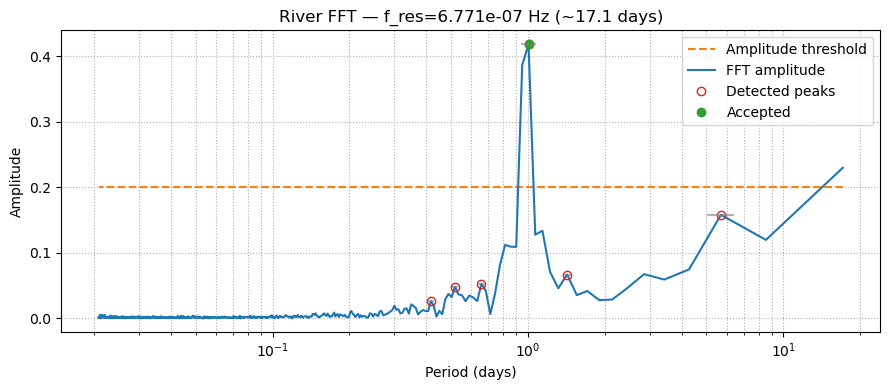

In [41]:
Pd, f0, A0, meta = fa.find_dominant_periods(store=True, compute_phases=True, amplitude_threshold=0.2, Q_min=5)

This deals only with 1D attenuation (no lateral flow).
Detected depths: [0.  0.1 0.2 0.3 0.4]
Amplitudes at dominant periods for each signal computed.
Period 1.01 days: Amplitudes = [0.39836225 0.25674256 0.08090495 0.01677865 0.00619806]


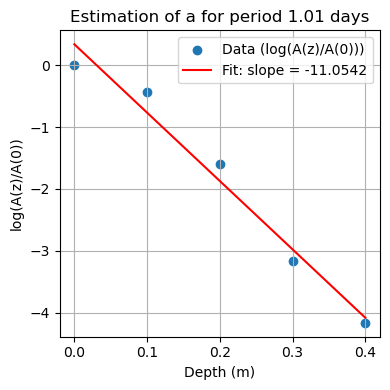

Attenuation coefficients a estimated for each dominant period.
Period 1.01 days: a = 11.0542 1/m
Period 1.01 days: R^2 = 0.9728


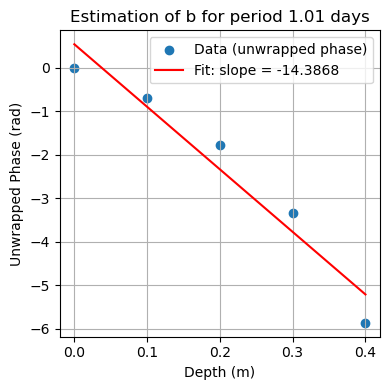

Phase decay coefficients b estimated for each dominant period.
Period 1.01 days: b = 14.3868 rad/m
Period 1.01 days: R^2 = 0.9426


In [42]:
a_est, a_R2 = fa.estimate_a(draw=True)     # lit dates/signals/depths/Pd depuis le state
b_est, b_R2 = fa.estimate_b(draw=True)                    # idem

Now we can retrieve the $\kappa_e$ and $v_t$ values

In [43]:
kappa_e, v_t = fa.perform_inversion(verbose=True)         # lit a,b,Pd du state

Inversion complete.
Period 1.01 days: kappa_e = 1.688e-07 m^2/s, v_t = 1.295e-06 m/s


### Checking for 2D hypothesis

In [44]:
#from pyheatmy.frequency2D import TwoDTester, TwoDConfig
from pyheatmy.frequency2D_upd import TwoDConfig, decide_for_fa_period

Check if 2D or 1D model using statistical tests.

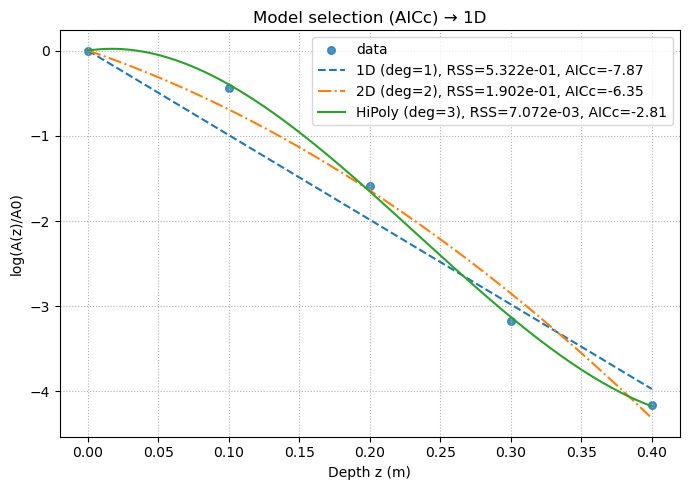

Best model according to criterias : 1D
AICc: -7.86791653348878 -6.346230322142663 -2.805558112834298
p_LRT 1 vs 2: 0.15140955948264456  | p_LRT 2 vs H: 0.010291494887499475


In [45]:
tester_cfg = TwoDConfig(through_origin=True, alpha_lrt=0.05)
dec = decide_for_fa_period(fa, period_index=0, config=tester_cfg, show_plot=True)
print("Best model according to criterias :", dec.which)
print("AICc:", dec.metrics["aicc_deg1"], dec.metrics["aicc_deg2"], dec.metrics["aicc_degh"])
print("p_LRT 1 vs 2:", dec.metrics["p_LRT_1_vs_2"], " | p_LRT 2 vs H:", dec.metrics["p_LRT_2_vs_H"])